# Using the TFA toolbox

   Imports:

In [1]:
import datetime as dt
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import swarmpal.toolboxes.tfa.tfa_processor as tfa

Provide values for the parameters of the analysis.  The `dataset` can be chosen from one of the compatible magnetic data collections, and the `var` is a VirES-compatible variable string (see [viresclient](https://viresclient.readthedocs.io/en/latest/available_parameters.html) for more information). The "start" and "end" times must be given as a datetime object. If the data are required as they are, set the `remove_chaos_model` parameter to False. Otherwise, if the inputs are magnetic field data and the analysis requires subtraction of the model field, set the parameter to True. 

Cluster data, as downlaoded by CDAWeb can be side-loaded into a `TfaInput` instance. Fist read the data as normal.

In [2]:
fname = "C3_CP_FGM_SPIN_104449.txt"
cl_mag = np.genfromtxt(fname, comments='#', delimiter=[23, 14], 
                        skip_header=136, 
                        converters= {0: str, 1: float})
i=0
cl_mag_t = [dt.datetime.strptime(cl_mag[i][0], "b'%d-%m-%Y %H:%M:%S.%f'") 
            for i in range(len(cl_mag))]
cl_mag_t = np.array(cl_mag_t).astype(np.datetime64)
cl_mag_x = np.array([float(cl_mag[i][1]) for i in range(len(cl_mag))]).astype(np.float64)


Define the time limits for this analysis (must be contained within the file)

In [3]:
t_lims = [dt.datetime(2015, 3, 29, 17, 0, 0), dt.datetime(2015, 3, 29, 18, 59, 59)]

Create a TfaInput instance, but don't initialize it. Set the collection to a random value from one of the permitted choices for now. 

In [4]:
c = tfa.TfaInput(collection = "SW_OPER_MAGA_LR_1B", 
                start_time = t_lims[0], 
                end_time = t_lims[1],
                initialise = False, 
                varname="F", sampling_time = "PT4S",
                remove_chaos=False)

Insert the new data to the `xarray` of the `TfaInput` and rename the collection to something that makes sense.

In [5]:
data_vars = {'F':(['Timestamp'], cl_mag_x, 
                          {'units': 'nT'})}
coords = {"Timestamp": (["Timestamp"], cl_mag_t)}
attrs = {}
c.xarray = xr.Dataset(data_vars, coords, attrs)

c.COLLECTION = "C3_CP_FGM_SPIN"

From now on, proceed as normal

In [6]:
processor = tfa.TfaProcessor(c, active_variable={"varname": "F"})

In [7]:
processor.interp_nans()

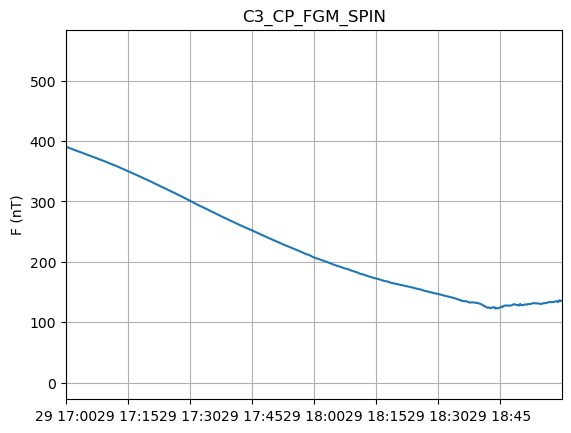

In [8]:
processor.plotX()

In [9]:
f = tfa.Filtering({"Sampling_Rate": 1/processor.input_data.SAMPLING_TIME, "Cutoff": 20 / 1000})
processor.apply(f)

(-1.0, 1.0)

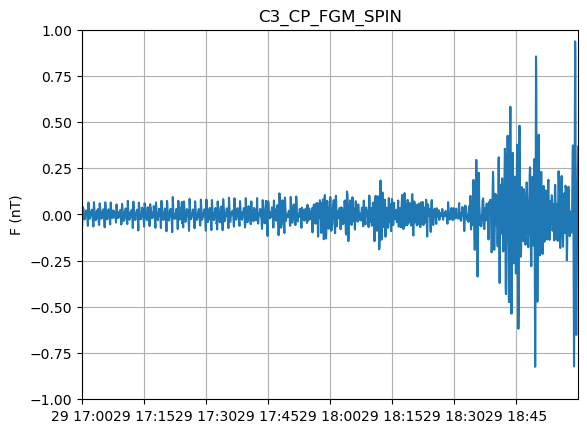

In [10]:
processor.plotX()
plt.ylim([-1, 1])

In [11]:
w = tfa.Wavelet({'Time_Step': processor.input_data.SAMPLING_TIME, 'Min_Scale': 1000/100, 'Max_Scale': 1000/20, 'dj': 0.1})
processor.apply(w)

C:\Users\magek\anaconda3\envs\swarmpal\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
C:\Users\magek\anaconda3\envs\swarmpal\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


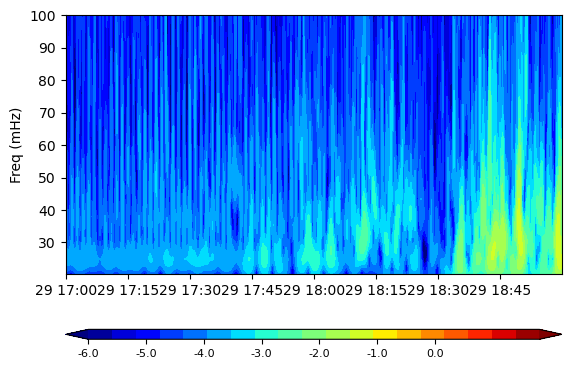

In [12]:
processor.image()